# Mind the Gap: Predicting TTC Subway Delays with a Machine Learning Approach

Authors: Petru Codrescu, Andre Sanchez-Plehn, Sean Euguene Chua, Julia Tan

**Introduction**



In hopes of better understanding delays and hopefully improving subway line service, our project analyzes the unique relationship between delay times, stations, and days of the week in hopes of understanding and predicting subway line movements.

The data used for this analysis comes from the **City of Toronto Open Data Portal** and the offered data from the **Datathon**. This consitutes two years of subway line service (2023 from the Open Data Portal and 2024 from the Datathon).

We decided to use data from 2023 as it was a natural complement to our 2024 file as both came from the same source, provided more insight, and gave us 2 years with consistent trends (i.e not influenced by the pandemic or other line changes) to make our model and analysis more predictable and accurate. We also used the TTC Ridership Report for 2023-2024 to help justify our recommendations at the end of our analysis.

With this analysis we created a predictive model with insights on how to improve the line near what we deem as crucial hotspots for most subway delays and failures.

*Disclosure:* Code was generated with assistance of Generative AI tools such as Chat GPT, and Github Copilot.

Other Files Attached: The preprocessing file, the final csv file (will be explained later), the original two csv files, and the report.

#### Imports

Below are the libraries we used to help create visualizations, models, and cleaning of the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import plotly

import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#### Subway Data Cleaning and Preview

After our preliminary cleaning, we personally went through the data and manually removed faulty entries and close subway stations. The final **compiled** data set (with both years of data) and fully cleaned is the filtered_final_subway_delays_2023-2024.csv (which is attached in our submission).

In [ ]:
# Load dataset
df = pd.read_csv("filtered_final_subway_delays_2023-2024.csv", parse_dates=["Date"])  # Ensure Date column is parsed as datetime

df = df[~df['Station'].isin(['MCCOWAN', 'ELLESMERE'])]

# Extract the year
df["Year"] = df["Date"].dt.year

# Split into 2023 and 2024 DataFrames
df2023 = df[df["Year"] == 2023]
df2024 = df[df["Year"] == 2024]

# Save to CSV
df2023.to_csv("data_2023.csv", index=False)
df2024.to_csv("data_2024.csv", index=False)

Below are how the data for each year looks in a tabular format.

In [ ]:
df2023

,Date,Time,Day,Station,Code,min_delay,min_gap,Bound,Line,Vehicle,Year
0,2023-01-01,02:22,Sunday,MUSEUM,MUPAA,3,9,S,YU,5931,2023
1,2023-01-01,02:30,Sunday,KIPLING,MUIS,0,0,E,BD,5341,2023
2,2023-01-01,02:33,Sunday,WARDEN,SUO,0,0,W,BD,0,2023
3,2023-01-01,03:17,Sunday,KEELE,MUIS,0,0,NaN,BD,0,2023
4,2023-01-01,07:16,Sunday,BATHURST,MUIS,0,0,NaN,BD,0,2023
...,...,...,...,...,...,...,...,...,...,...,...
22669,2023-12-31,12:25,Sunday,SHEPPARD,MUIR,7,14,W,SHP,6196,2023
22670,2023-12-31,13:53,Sunday,BAYVIEW,TUSC,0,0,E,SHP,6191,2023
22671,2023-12-31,14:57,Sunday,SHEPPARD,MUO,51,58,W,SHP,6171,2023
22672,2023-12-31,15:15,Sunday,BAYVIEW,TUOPO,7,14,E,SHP,6141,2023


In [ ]:
df2024

,Date,Time,Day,Station,Code,min_delay,min_gap,Bound,Line,Vehicle,Year
22674,2024-01-01,02:00,Monday,SHEPPARD,MUI,0,0,N,YU,5491,2024
22675,2024-01-01,02:00,Monday,DUNDAS,MUIS,0,0,N,YU,0,2024
22676,2024-01-01,02:08,Monday,DUNDAS,MUPAA,4,10,N,YU,6051,2024
22677,2024-01-01,02:13,Monday,KENNEDY,PUTDN,10,16,E,BD,5284,2024
22678,2024-01-01,02:22,Monday,BLOOR,MUPAA,4,10,N,YU,5986,2024
...,...,...,...,...,...,...,...,...,...,...,...
44451,2024-10-31,13:34,Thursday,SHEPPARD,EUSC,0,0,E,SHP,6156,2024
44452,2024-10-31,13:42,Thursday,LESLIE,PUOPO,9,16,E,SHP,6156,2024
44453,2024-10-31,14:09,Thursday,LESLIE,PUOPO,6,13,E,SHP,6156,2024
44454,2024-10-31,14:30,Thursday,SHEPPARD,PUOPO,7,14,W,SHP,6151,2024


2023 Numerical Analysis for Delay Times

When a row in min_delay would have 0 minutes, it means that delay was less than a minute. Using this information we made an important decision that influenced the rest of our analysis.

We **only** considered trains delayed if the min_delay was greater than or equal to one minute. This allowed us to compare proportions of trains being on time and being delayed, while offering our later model a way to distinguish between being late and being on time. (Plus being only 15 seconds late or 40 seconds late has a negligible affect on service.)

In [ ]:
#Average of all train's arrival times (2023)

df2023['min_delay'].mean()

2.897990932527336

In [ ]:
#Creates a dataframe that contains only values for delayed trains (2023)

df2023_all_delay = df2023[df2023['min_delay'] > 0]

In [ ]:
df2023_all_delay

,Date,Time,Day,Station,Code,min_delay,min_gap,Bound,Line,Vehicle,Year
0,2023-01-01,02:22,Sunday,MUSEUM,MUPAA,3,9,S,YU,5931,2023
7,2023-01-01,08:02,Sunday,VAUGHAN,TUNOA,6,12,S,YU,5451,2023
8,2023-01-01,08:11,Sunday,GREENWOOD,MUNOA,5,10,E,BD,0,2023
10,2023-01-01,08:15,Sunday,KEELE,TUNOA,5,10,W,BD,0,2023
11,2023-01-01,08:16,Sunday,GREENWOOD,TUNOA,5,10,E,BD,0,2023
...,...,...,...,...,...,...,...,...,...,...,...
22662,2023-12-31,01:20,Sunday,WELLESLEY,MUIR,15,21,N,YU,5406,2023
22667,2023-12-31,01:46,Sunday,WELLESLEY,MUPAA,4,10,N,YU,5576,2023
22669,2023-12-31,12:25,Sunday,SHEPPARD,MUIR,7,14,W,SHP,6196,2023
22671,2023-12-31,14:57,Sunday,SHEPPARD,MUO,51,58,W,SHP,6171,2023


In [ ]:
#Average of all the delayed train's arrival times (2023)

df2023_all_delay['min_delay'].mean()

8.113364858138377

2024 Numerical Analysis for Delay Times

In [ ]:
#Average of all train's arrival times (2024)

df2024['min_delay'].mean()

2.827486454219855

In [ ]:
#Creates a dataframe that contains only values for delayed trains (2024)

df2024_all_delay = df2024[df2024['min_delay'] > 0]

In [ ]:
df2024_all_delay

,Date,Time,Day,Station,Code,min_delay,min_gap,Bound,Line,Vehicle,Year
22676,2024-01-01,02:08,Monday,DUNDAS,MUPAA,4,10,N,YU,6051,2024
22677,2024-01-01,02:13,Monday,KENNEDY,PUTDN,10,16,E,BD,5284,2024
22678,2024-01-01,02:22,Monday,BLOOR,MUPAA,4,10,N,YU,5986,2024
22679,2024-01-01,02:25,Monday,ST CLAIR,MUPAA,3,9,N,YU,6051,2024
22681,2024-01-01,02:27,Monday,WOODBINE,EUDO,7,13,E,BD,5077,2024
...,...,...,...,...,...,...,...,...,...,...,...
44447,2024-10-31,09:56,Thursday,BESSARION,PUOPO,4,11,E,SHP,6156,2024
44452,2024-10-31,13:42,Thursday,LESLIE,PUOPO,9,16,E,SHP,6156,2024
44453,2024-10-31,14:09,Thursday,LESLIE,PUOPO,6,13,E,SHP,6156,2024
44454,2024-10-31,14:30,Thursday,SHEPPARD,PUOPO,7,14,W,SHP,6151,2024


In [ ]:
#Average of all the delayed train's arrival times (2023)

df2024_all_delay['min_delay'].mean()

7.90157833953548

Numerical Analysis of Most Frequent Delayed Stations 2023

Here we analyzed and located which subway stations had the most traffic and which ones had most amount of delays.

In [ ]:
df2023['Station'].value_counts()

,count
Station,
DUNDAS,1087
KENNEDY,1056
FINCH,903
BLOOR,880
YONGE,871
...,...
LESLIE,130
CHESTER,130
GLENCAIRN,98


In [ ]:
df2023_all_delay['Station'].value_counts()

,count
Station,
EGLINTON,361
KENNEDY,360
SHEPPARD,338
FINCH,323
KIPLING,300
...,...
OLD,51
LESLIE,47
RUNNYMEDE,45


Note that in 2023 the stations with the most delays were Eglinton, Kennedy, Sheppard, and Finch. This was intriguing as we intially believed that stations with the largest volume of traffic (such as Dundas or Bloor as seen in the first table) would have the most amount of delays.

We hypothesize that although high volume stations have significantly higher number of delayed trains compared to smaller stations, the TTC manages these station with more resources, hence leading to there not being a very strong correlation between station size and number of delayed trains.

Numerical Analysis of Most Frequent Delayed Stations 2024



In [ ]:
df2024['Station'].value_counts() #same as above

,count
Station,
DUNDAS,982
BLOOR,973
FINCH,943
YONGE,848
SHEPPARD,822
...,...
PIONEER,120
GLENCAIRN,118
BAYVIEW,105


In [ ]:
df2024_all_delay['Station'].value_counts()

,count
Station,
EGLINTON,375
FINCH,333
SHEPPARD,319
ST CLAIR,313
ST GEORGE,295
...,...
BAYVIEW,42
LESLIE,41
PIONEER,39


In 2024, we saw similar trends to those in 2023. Where Dundas, Bloor, and Finch were in the top 5 for volume of trains and once again stations such as Eglinton, Finch, and Sheppard once again being in the top 5 for most delayed trains.

This further supports our hypothesis that the TTC spends more resources on high volume stations in hopes of reducing delayed trains however, this leads to other stations suffering from high number of delays (especially and transfer stations like Bloor and Sheppard).

#### Summary Statistics

Below are some visualizations to better understand our data.

In [ ]:
column1 = 'Total Frequency'
column2 = 'Number of Delays'
bins = 64

# Count occurrences of each station in both datasets
count_2023 = df2023['Station'].value_counts()
count_2023_delays = df2023_all_delay['Station'].value_counts()

# Get all unique stations from both datasets
stations = sorted(set(count_2023.index).union(set(count_2023_delays.index)))

# Get frequencies for each station (fill missing with 0)
freq_2023 = [count_2023.get(station, 0) for station in stations]
freq_2023_delays = [count_2023_delays.get(station, 0) for station in stations]

# Set bar width and positions
x = np.arange(len(stations))
width = 0.4

# Create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=stations,
    y=freq_2023,
    name=column1,
    marker={'color': 'rgba(135, 206, 250, 0.8)'} # Soft sky blue
))

fig.add_trace(go.Bar(
    x=stations,
    y=freq_2023_delays,
    name=column2,
    marker={'color': 'rgba(144, 238, 144, 0.8)'}  # Soft pastel green
))

# Update layout for a soft dark background
fig.update_layout(
    title='Bar Plot of Both Datasets in 2023',
    xaxis_title='Station',
    yaxis_title='Frequency',
    barmode='group',
    xaxis_tickangle=-90,
    bargap=0.2,
    bargroupgap=0.1,
    width=2000,
    height=1200,
    paper_bgcolor='#1e1e1e',  # Dark, soft background
    plot_bgcolor='#1e1e1e',   # Same dark background inside the plot
    font=dict(family="Arial, sans-serif", size=16, color="white"),
    xaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.2)',  # Light gray gridlines for soft contrast
        tickfont=dict(color="white")
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.2)',  # Light gray gridlines for better readability
        tickfont=dict(color="white")
    ),
    legend=dict(
        bgcolor='rgba(50, 50, 50, 0.7)',  # Soft dark legend background
        bordercolor='rgba(100, 100, 100, 0.7)',
        borderwidth=1,
        font=dict(color="white")
    )
)

# Show the interactive plot
fig.show()


In [ ]:
# Count occurrences of each station in both datasets
count_2024 = df2024['Station'].value_counts()
count_2024_delays = df2024_all_delay['Station'].value_counts()

# Get all unique stations from both datasets
stations = sorted(set(count_2024.index).union(set(count_2024_delays.index)))

# Get frequencies for each station (fill missing with 0)
freq_2024 = [count_2024.get(station, 0) for station in stations]
freq_2024_delays = [count_2024_delays.get(station, 0) for station in stations]

# Create the bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=stations,
    y=freq_2024,
    name=column1,
    marker={'color': 'rgba(135, 206, 250, 0.8)'}  # Soft sky blue
))

fig.add_trace(go.Bar(
    x=stations,
    y=freq_2024_delays,
    name=column2,
    marker={'color': 'rgba(144, 238, 144, 0.8)'}  # Soft pastel green
))

# Update layout for a soft dark background
fig.update_layout(
    title='Bar Plot of Both Datasets in 2024',
    xaxis_title='Station',
    yaxis_title='Frequency',
    barmode='group',
    xaxis_tickangle=-90,
    bargap=0.2,
    bargroupgap=0.1,
    width=2000,
    height=1200,
    paper_bgcolor='#1e1e1e',  # Soft dark background
    plot_bgcolor='#1e1e1e',   # Same dark background inside the plot
    font=dict(family="Arial, sans-serif", size=16, color="white"),
    xaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.2)',  # Light gray gridlines for soft contrast
        tickfont=dict(color="white")
    ),
    yaxis=dict(
        gridcolor='rgba(200, 200, 200, 0.2)',  # Light gray gridlines for better readability
        tickfont=dict(color="white")
    ),
    legend=dict(
        bgcolor='rgba(50, 50, 50, 0.7)',  # Soft dark legend background
        bordercolor='rgba(100, 100, 100, 0.7)',
        borderwidth=1,
        font=dict(color="white")
    )
)

# Show the interactive plot
fig.show()


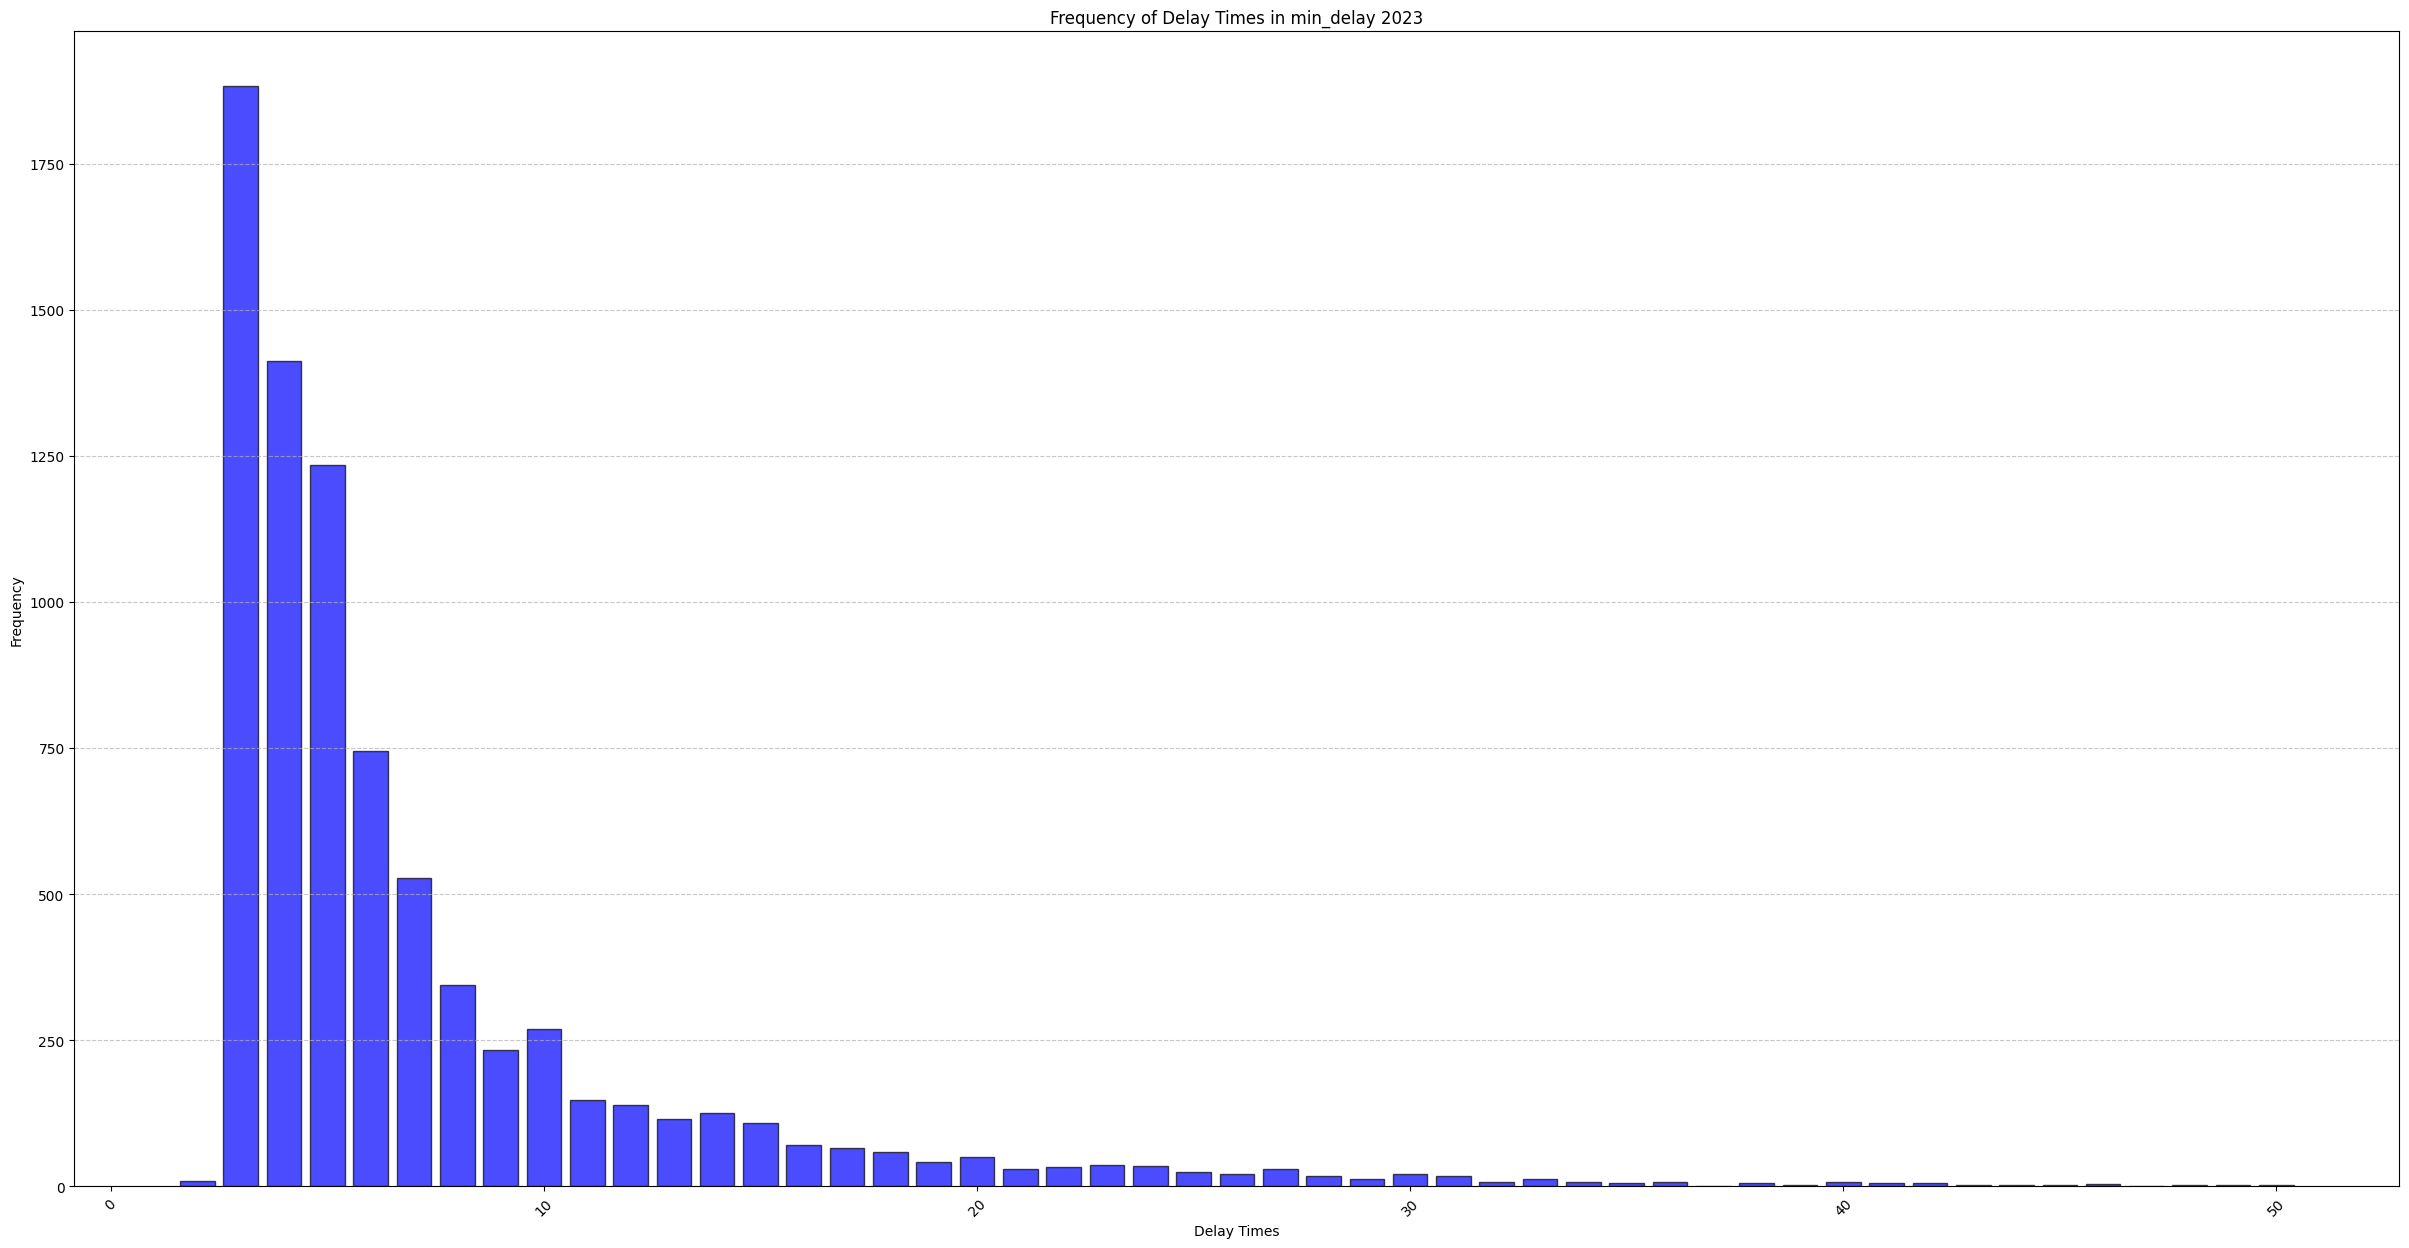

In [ ]:
# Assuming your DataFrame is named df and the column you want is 'your_column'
column = 'min_delay'

# Get the frequency of each unique value and filter for values <= 200
value_counts = df2023_all_delay[column].value_counts().sort_index()
value_counts = value_counts[value_counts.index <= 50]  # Keep only values ≤ 200

plt.figure(figsize=(30, 15))

plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, edgecolor='black')

plt.xlabel('Delay Times')
plt.ylabel('Frequency')
plt.title(f'Frequency of Delay Times in {column} 2023')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


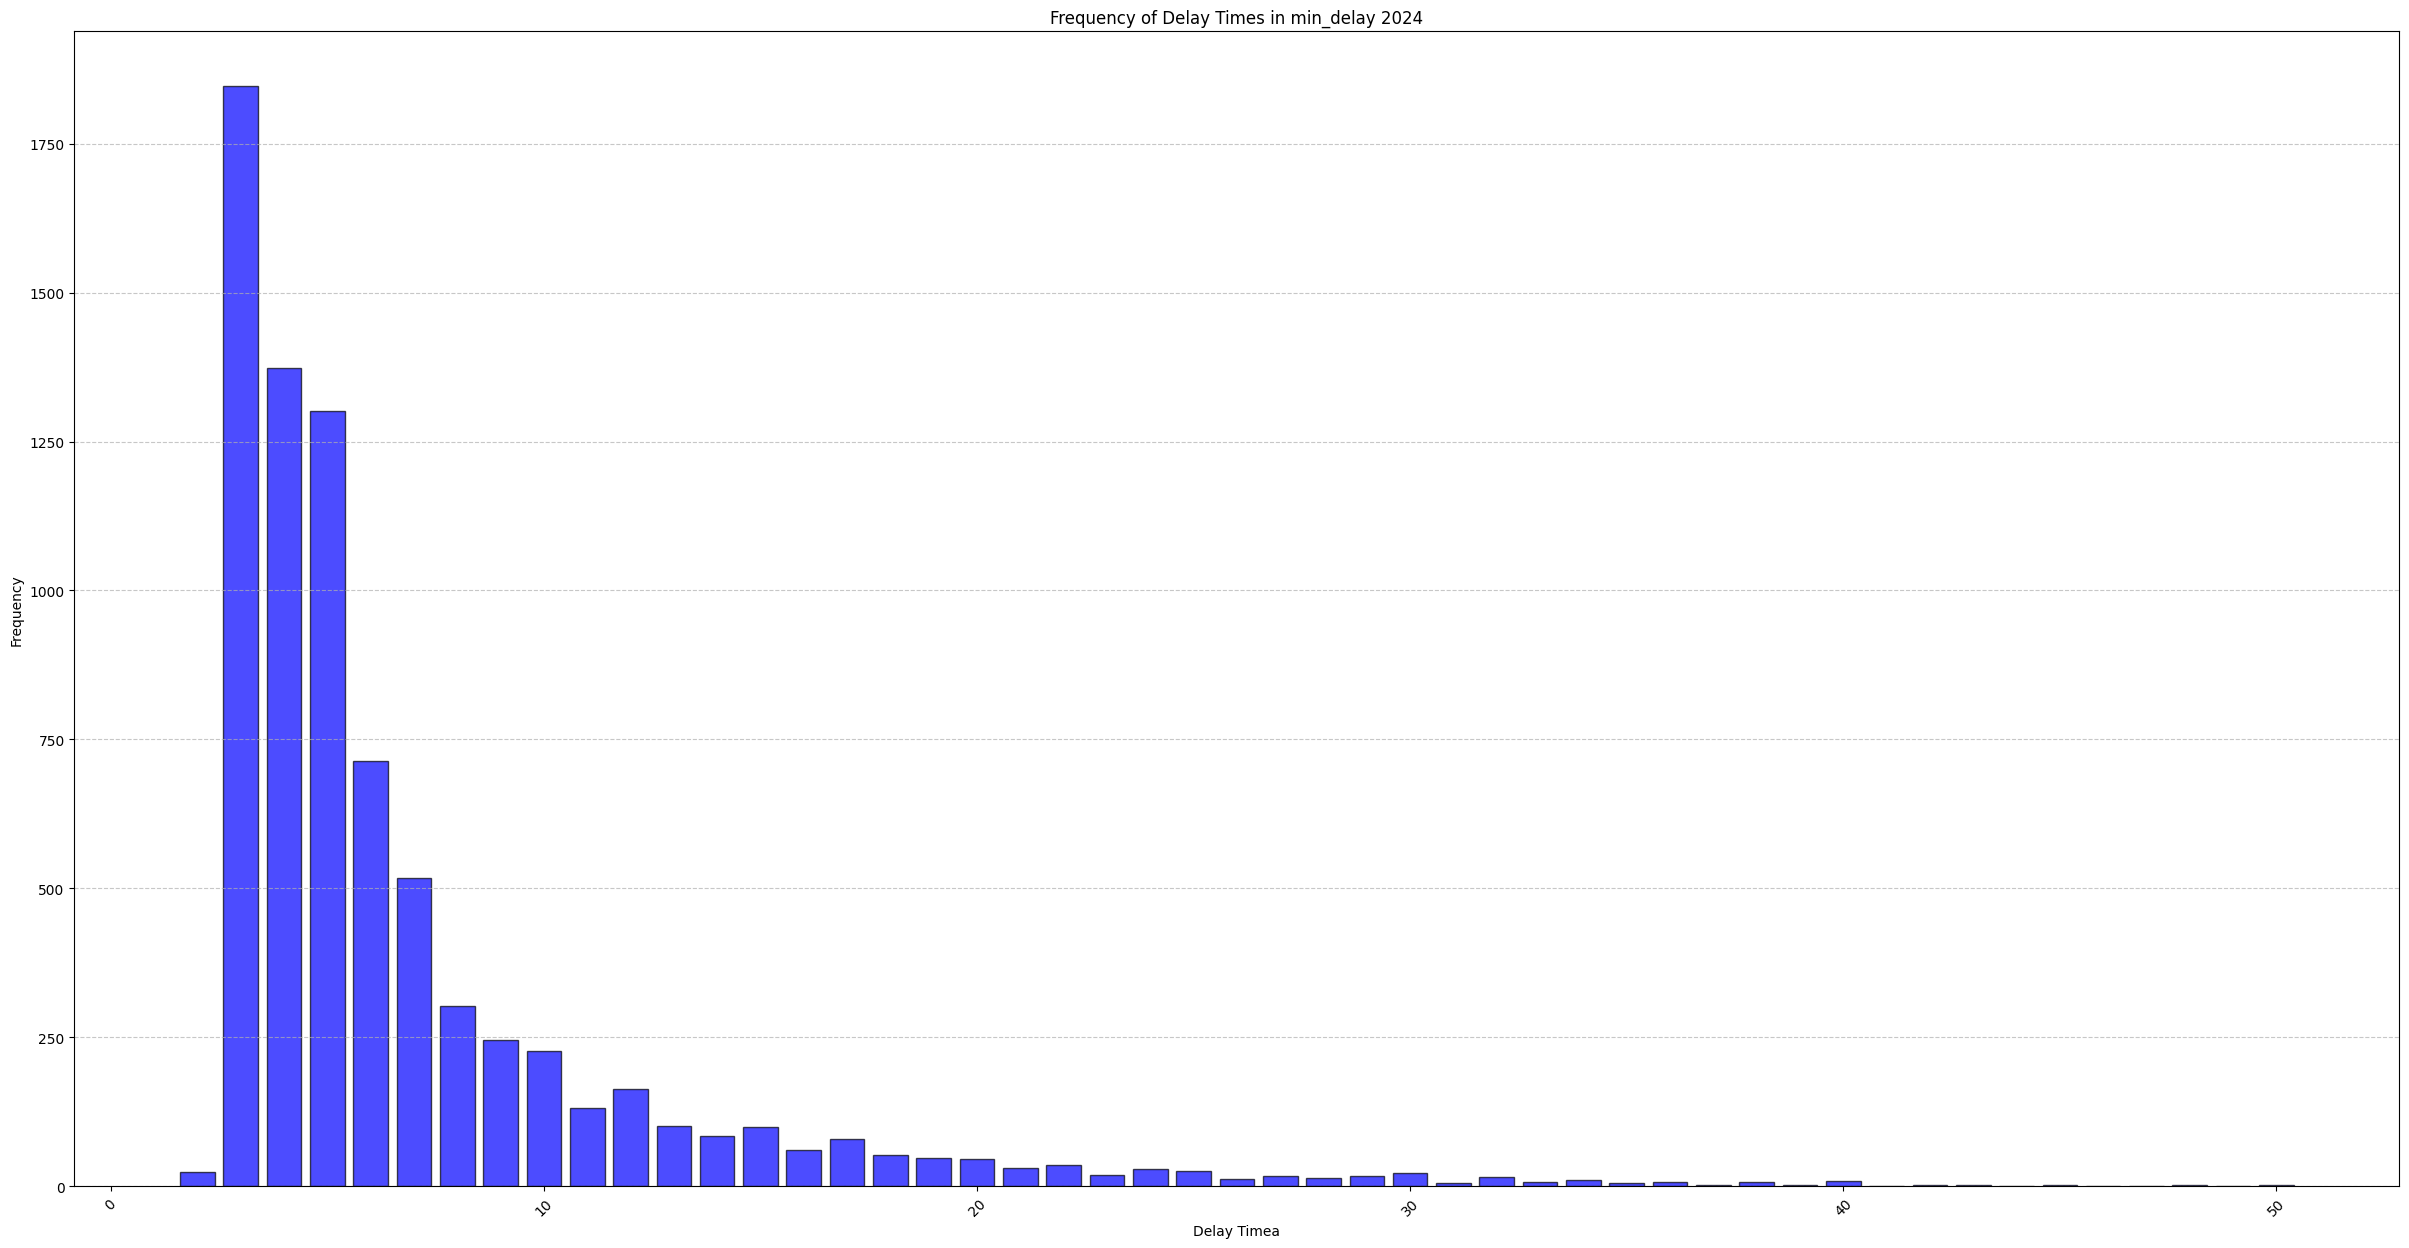

In [ ]:
# Assuming your DataFrame is named df and the column you want is 'your_column'
column = 'min_delay'

# Get the frequency of each unique value and filter for values <= 200
value_counts = df2024_all_delay[column].value_counts().sort_index()
value_counts = value_counts[value_counts.index <= 50]  # Keep only values ≤ 200

plt.figure(figsize=(30, 15))

plt.bar(value_counts.index, value_counts.values, color='blue', alpha=0.7, edgecolor='black')

plt.xlabel('Delay Timea')
plt.ylabel('Frequency')
plt.title(f'Frequency of Delay Times in {column} 2024')
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [ ]:
import plotly.graph_objects as go

# Get the frequency of each unique value
column = 'Code'
value_counts = df2024_all_delay[column].value_counts()

# Create an interactive bar plot
fig = go.Figure(data=[go.Bar(
    x=value_counts.index,
    y=value_counts.values,
    marker=dict(color='blue', opacity=0.7, line=dict(color='black', width=1)),
    hovertemplate="Value: %{x}<br>Frequency: %{y}<extra></extra>"  # Customize the hover data
)])

# Customize layout
fig.update_layout(
    title=f'Bar Plot of {column} 2023',
    xaxis_title='Breakdown Code',
    yaxis_title='Frequency',
    xaxis_tickangle=45,  # Rotate x-axis labels for readability
    template='plotly_white',  # Clean theme
    showlegend=False
)

# Show the interactive plot
fig.show()


In [ ]:
import plotly.graph_objects as go

# Get the frequency of each unique value
column = 'Code'
value_counts = df2024_all_delay[column].value_counts()

# Create an interactive bar plot
fig = go.Figure(data=[go.Bar(
    x=value_counts.index,
    y=value_counts.values,
    marker=dict(color='blue', opacity=0.7, line=dict(color='black', width=1)),
    hovertemplate="Value: %{x}<br>Frequency: %{y}<extra></extra>"  # Customize the hover data
)])

# Customize layout
fig.update_layout(
    title=f'Bar Plot of {column} 2024',
    xaxis_title='Breakdown Code',
    yaxis_title='Frequency',
    xaxis_tickangle=45,  # Rotate x-axis labels for readability
    template='plotly_white',  # Clean theme
    showlegend=False
)

# Show the interactive plot
fig.show()


#### Main Model

Finally, below is our predictive model. We used a Neural Network to predict min_delay by using the station and days of the week. Since we had only 2 years worth of data (going back any further would use data from the height of the pandemic which would of skewed our results due to lower ridership levels and by implication lower number of breakdowns), we decided on instead of predicting the exact time or the exact type of breakdown, how long each delay would be if it did occur on this day for this station. This allows our model to be more generalizable as seen with the 1.055 test root mean squared error.

We used a number of different methods to increase the accuracy of our model such as stopping the model early if it began to overfit, working with the learning rate, and regularization.

Despite this we found our model to be quite accurate in predicting time delays for each station and found that it aligns with our personal experience and with what the TTC Ridership reports state.

In [ ]:
# Set random seeds for reproducibility
SEED = 21
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Load the data
data_delay_20232024 = df

# Convert Date column to datetime
data_delay_20232024['Date'] = pd.to_datetime(data_delay_20232024['Date'])
data_delay_20232024['DayOfWeek'] = data_delay_20232024['Date'].dt.day_name()

# Drop "Code" since we only want (Station, DayOfWeek)
data_delay_20232024 = data_delay_20232024[['DayOfWeek', 'Station', 'min_delay']]

# Ensure every station has a row for each day of the week
all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
all_stations = data_delay_20232024['Station'].unique()

# Create a full (DayOfWeek, Station) dataframe
full_index = pd.MultiIndex.from_product([all_days, all_stations], names=['DayOfWeek', 'Station'])
full_df = pd.DataFrame(index=full_index).reset_index()

# Merge with actual data and fill missing values with station's mean delay
grouped_data = data_delay_20232024.groupby(['DayOfWeek', 'Station'], as_index=False)['min_delay'].mean()
full_grouped_data = full_df.merge(grouped_data, on=['DayOfWeek', 'Station'], how='left')

# Fill missing delay values with the station's average delay
station_avg_delays = full_grouped_data.groupby('Station')['min_delay'].transform(lambda x: x.fillna(x.mean()))
full_grouped_data['min_delay'] = station_avg_delays

# If any station has NaN delays (e.g., new station), fill with overall mean
full_grouped_data['min_delay'].fillna(full_grouped_data['min_delay'].mean(), inplace=True)

# One-hot encode categorical variables
categorical_features = ['DayOfWeek', 'Station']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Standardize numerical values
scaler = StandardScaler()

# Column transformer
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features)
])

# Split data into features (X) and target (y)
X = full_grouped_data.drop('min_delay', axis=1)
y = full_grouped_data['min_delay'].values.reshape(-1, 1)  # Reshape for scaling

# Train-Validation-Test split (80-10-10)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)
y_val = y_scaler.transform(y_val)
y_test = y_scaler.transform(y_test)

# Transform categorical variables
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),  # Drop 30% neurons
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

# Compile model with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_val, y_val),
                    batch_size=32,
                    callbacks=[early_stopping])

# Predict on validation and test sets
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

# Reverse scaling for predictions
y_val_pred = y_scaler.inverse_transform(y_val_pred)
y_test_pred = y_scaler.inverse_transform(y_test_pred)

# Compute mean squared error
val_mse = mean_squared_error(y_scaler.inverse_transform(y_val), y_val_pred)
test_mse = mean_squared_error(y_scaler.inverse_transform(y_test), y_test_pred)
val_rmse = np.sqrt(val_mse)
test_rmse = np.sqrt(test_mse)

# Print RMSE results
print(f'Validation RMSE: {val_rmse}')
print(f'Test RMSE: {test_rmse}')

# Predict for (DayOfWeek, Station) pairs
X_unique = preprocessor.transform(full_grouped_data.drop(columns=['min_delay']))
predictions = model.predict(X_unique)

# Store predictions in the grouped dataframe
full_grouped_data['predicted_min_delay'] = y_scaler.inverse_transform(predictions)

<ipython-input-49-d39947cabad5>:34: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.8919 - val_loss: 0.9999
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9184 - val_loss: 0.9963
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9102 - val_loss: 0.9930
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8768 - val_loss: 0.9900
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.8501 - val_loss: 0.9875
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8512 - val_loss: 0.9856
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8584 - val_loss: 0.9837
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8660 - val_loss: 0.9825
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8744 - val_loss: 0.9804
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8539 - val_loss: 0.9787
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8380 - val_loss: 0.9763
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8

In [ ]:
import pandas as pd

# Create a DataFrame for MSE values
model_summary = pd.DataFrame({
    "Metric": ["Validation RMSE", "Test RMSE"],
    "Value": [val_rmse, test_rmse]
})

# Print the full model summary
print("="*50)
print(" Model Summary ")
print("="*50)
print("Neural Network Architecture:")
print("- Input Layer: Encodes categorical features (DayOfWeek, Station)")
print("- Hidden Layers:")
print("  * Dense(64, ReLU) + Dropout(30%)")
print("  * Dense(32, ReLU) + Dropout(30%)")
print("- Output Layer: Single neuron for predicted delay")
print("- Optimizer: Adam (learning rate = 0.0005)")
print("- Loss Function: Root Mean Squared Error (RMSE)")
print("- Regularization: Dropout (30%)")
print("- Early Stopping: Enabled (patience = 5 epochs)")
print("="*50)

# Display the table of MSE values
print("\nModel Performance:")
print(model_summary.to_string(index=False))


 Model Summary 
Neural Network Architecture:
- Input Layer: Encodes categorical features (DayOfWeek, Station)
- Hidden Layers:
  * Dense(64, ReLU) + Dropout(30%)
  * Dense(32, ReLU) + Dropout(30%)
- Output Layer: Single neuron for predicted delay
- Optimizer: Adam (learning rate = 0.0005)
- Loss Function: Root Mean Squared Error (RMSE)
- Regularization: Dropout (30%)
- Early Stopping: Enabled (patience = 5 epochs)

Model Performance:
         Metric    Value
Validation RMSE 1.409750
      Test RMSE 1.054589


In [ ]:
full_grouped_data

,DayOfWeek,Station,min_delay,predicted_min_delay
0,Monday,MUSEUM,6.054054,3.847412
1,Monday,KIPLING,2.326923,2.518255
2,Monday,WARDEN,5.606299,3.326987
3,Monday,KEELE,2.891304,2.989506
4,Monday,BATHURST,1.293478,2.279451
...,...,...,...,...
443,Sunday,GLENCAIRN,4.125000,3.923285
444,Sunday,LESLIE,1.481481,2.523341
445,Sunday,ROSEDALE,5.333333,4.583249
446,Sunday,BESSARION,9.666667,3.396433


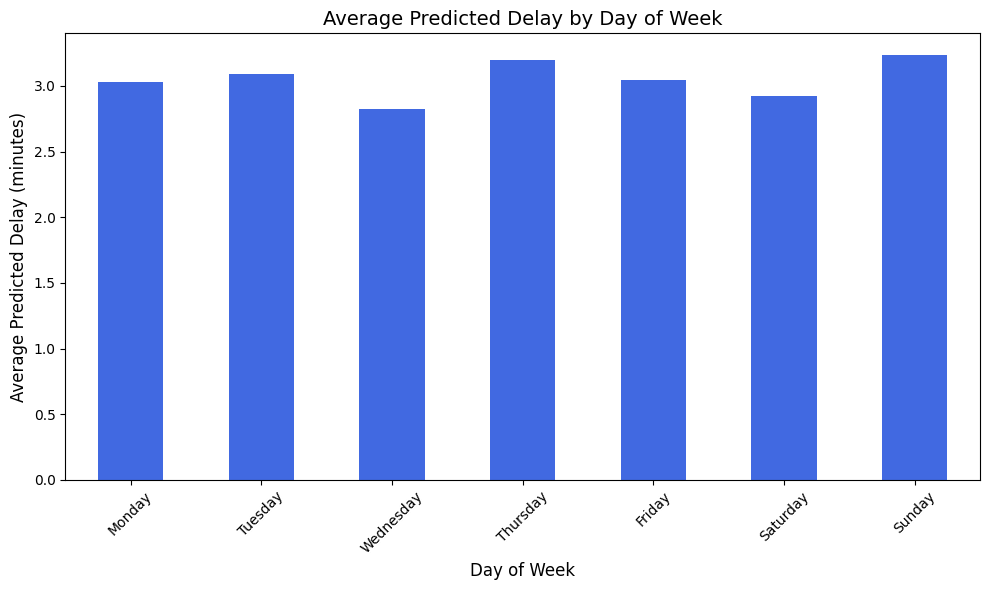

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, widgets, HBox, VBox
import io

df = full_grouped_data

# Create a heatmap function with sorting options
def create_heatmap(day_of_week='All', sort_by='Alphabetical'):
    plt.figure(figsize=(14, 20))

    if day_of_week == 'All':
        # For all days, create a pivot table
        pivot_data = df.pivot_table(
            index='Station',
            columns='DayOfWeek',
            values='predicted_min_delay',
            aggfunc='mean'
        )

        # Reorder days of week
        day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        pivot_data = pivot_data.reindex(columns=day_order)

        # Sort stations based on user selection
        if sort_by == 'Delay Time':
            # Calculate the mean delay across all days
            pivot_data['mean_delay'] = pivot_data.mean(axis=1)
            pivot_data = pivot_data.sort_values('mean_delay', ascending=False)
            pivot_data = pivot_data.drop(columns=['mean_delay'])
        else:  # 'Alphabetical'
            pivot_data = pivot_data.sort_index()

        # Create the heatmap
        ax = sns.heatmap(
            pivot_data,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Predicted Minimum Delay (minutes)'}
        )
        plt.title(f'TTC Station Predicted Delays - All Days of Week (Sorted {sort_by})', fontsize=16)

    else:
        # Filter for the selected day
        day_data = df[df['DayOfWeek'] == day_of_week]

        # Sort based on user selection
        if sort_by == 'Delay Time':
            day_data = day_data.sort_values('predicted_min_delay', ascending=False)
        else:  # 'Alphabetical'
            day_data = day_data.sort_values('Station')

        # Create a DataFrame for the heatmap (station vs delay)
        heatmap_data = day_data[['Station', 'predicted_min_delay']].set_index('Station')

        # Create the heatmap
        ax = sns.heatmap(
            heatmap_data,
            cmap='Blues',
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cbar_kws={'label': 'Predicted Minimum Delay (minutes)'}
        )
        plt.title(f'TTC Station Predicted Delays - {day_of_week} (Sorted {sort_by})', fontsize=16)

    plt.ylabel('Station', fontsize=12)
    plt.xticks()
    plt.tight_layout()
    plt.show()

# Create interactive widgets
days = ['All'] + sorted(df['DayOfWeek'].unique().tolist())
day_dropdown = widgets.Dropdown(
    options=days,
    value='All',
    description='Day of Week:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

sort_dropdown = widgets.Dropdown(
    options=['Alphabetical', 'Delay Time'],
    value='Alphabetical',
    description='Sort Stations By:',
    style={'description_width': 'initial'},
    layout={'width': '300px'}
)

# Set up the interactive visualization with both widgets
def update_viz(day_of_week, sort_by):
    create_heatmap(day_of_week, sort_by)

# Display the interactive widgets
out = widgets.interactive_output(
    update_viz,
    {'day_of_week': day_dropdown, 'sort_by': sort_dropdown}
)

controls = HBox([day_dropdown, sort_dropdown])
display(VBox([controls, out]))

# Also provide a function to analyze the stations with highest and lowest delays
def analyze_delays():
    # Group by station and get average delay across all days
    station_avg = df.groupby('Station')['predicted_min_delay'].mean().sort_values(ascending=False)

    print("")

    # Group by day of week and get average delay across all stations
    day_avg = df.groupby('DayOfWeek')['predicted_min_delay'].mean()

    # Reorder days of week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_avg = day_avg.reindex(day_order)

    # Plot the day of week averages
    plt.figure(figsize=(10, 6))
    day_avg.plot(kind='bar', color='royalblue')
    plt.title('Average Predicted Delay by Day of Week', fontsize=14)
    plt.ylabel('Average Predicted Delay (minutes)', fontsize=12)
    plt.xlabel('Day of Week', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Run the analysis
analyze_delays()

#### Business Insight

The TTC Ridership reports from 2023-2024 is pdf document that list out the volume of passangers at each station per day. We found from our preliminary research and from these two documents that transfer stations (ones where a passenger gets off to switch lines) have some of the highest train delays. An example of this would be Sheppard Station, where with only 35,327 passangers they had one of the highest number of delays while only having a fifth of the volume of other stations such as Bloor with 156,643 passengers per day.

With this insight we can recommend the follow course of action to improve line service.

First, the TTC should continue to invest and maintain transfer stations such as Bloor-Yonge, Sheppard, and St.George. As these stations have the largest volume of passengers (excluding Sheppard) and are crucial hotspots for passengers as they transfer between lines.

Second, the TTC should maintain key stations from our visualizations such as Union, Eglinton, and King as although they are not terminal or transfer stations, they face some of the highest rates of delayed trains. This means these 3 stations are some of the most popular either because of work or for residential reasons.

Third and finally, the TTC should adjust service per day as seen with the results from our neural network model. An example of such an adjustment would be running fewer trains on a Wednesday as they have the smallest average delay time, meaning trains are more reliable on these days, meaning fewer would have to run, further reducing the chance of a train breakdown and creating a delay.

Hopefully with the recommendations above, the line service for the TTC will improve, further increasing public confidence in such services and furthering Toronto on a more sustainable future.